# How to Build an ARX Model

IN this example we will generate some SISO data to test 2 different Python pakages for system identification. At first we will write our own code for system identification, finally we will test two different libraries to test the validity of the paramters found. 

Let's strat by generating some data from a SISO system, and devide them into train and test

In [41]:
import numpy as np
import pandas as pd 
import scienceplots
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


plt.style.use('science')
np.random.seed(1)

In [42]:



def generate_siso_data(n, test_size=0.2, noise_level=0.1, a1=0.5, a2=-0.3, b1=0.7, b2=-0.2):
    """
    Generates synthetic Single Input Single Output (SISO) data for an ARX model with na=2 and nb=2.
    :param n: Number of data points to generate.
    :param test_size: Proportion of the dataset to include in the test split.
    :param noise_level: Standard deviation of the noise.
    :param a1, a2: Coefficients for the autoregressive part of the model.
    :param b1, b2: Coefficients for the exogenous input part of the model.
    :return: Tuple of (y_train, x_train, y_test, x_test), where y is the target series and x is the exogenous series.
    """
    # Generating exogenous input (x) as a random signal
    u = np.random.randint(0, 2, size=n)

    # Generating the target series (y)
    y = np.zeros(n)
    for t in range(2, n):
        y[t] = a1 * y[t-1] + a2 * y[t-2] +  b1 * u[t-1] + b2 * u[t-2] + np.random.normal(0, noise_level)

    # Splitting the data into training and testing sets
    y_train, y_test, u_train, u_test = train_test_split(y, u, test_size=test_size, shuffle=False)

    return y_train, u_train, y_test, u_test

In [43]:
y_train, u_train, y_test, u_test = generate_siso_data(n=1000, noise_level=0.05)

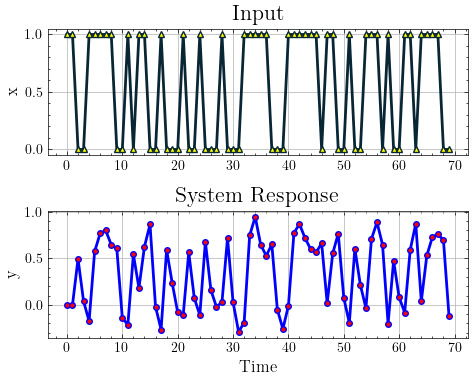

In [45]:
### Data Visualization
STEPS = 70
# Creating a 2-row plot for x and y
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 4))

axes[0].plot(u_train[:STEPS], color='#092635', linewidth=2, linestyle='-', marker='^', markersize=4, markerfacecolor='yellow')
axes[0].set_title('Input', fontsize=16)
axes[0].set_ylabel('x', fontsize=12)
axes[0].grid(True)
axes[1].plot(y_train[:STEPS], color='blue', linewidth=2, linestyle='-', marker='o', markersize=4, markerfacecolor='red')
axes[1].set_title('System Response', fontsize=16)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].grid(True)

plt.tight_layout()

# Save the plots as a PDF
plt.savefig('../img/response.pdf', format='pdf')

plt.show()

### How many Lags to consider? 

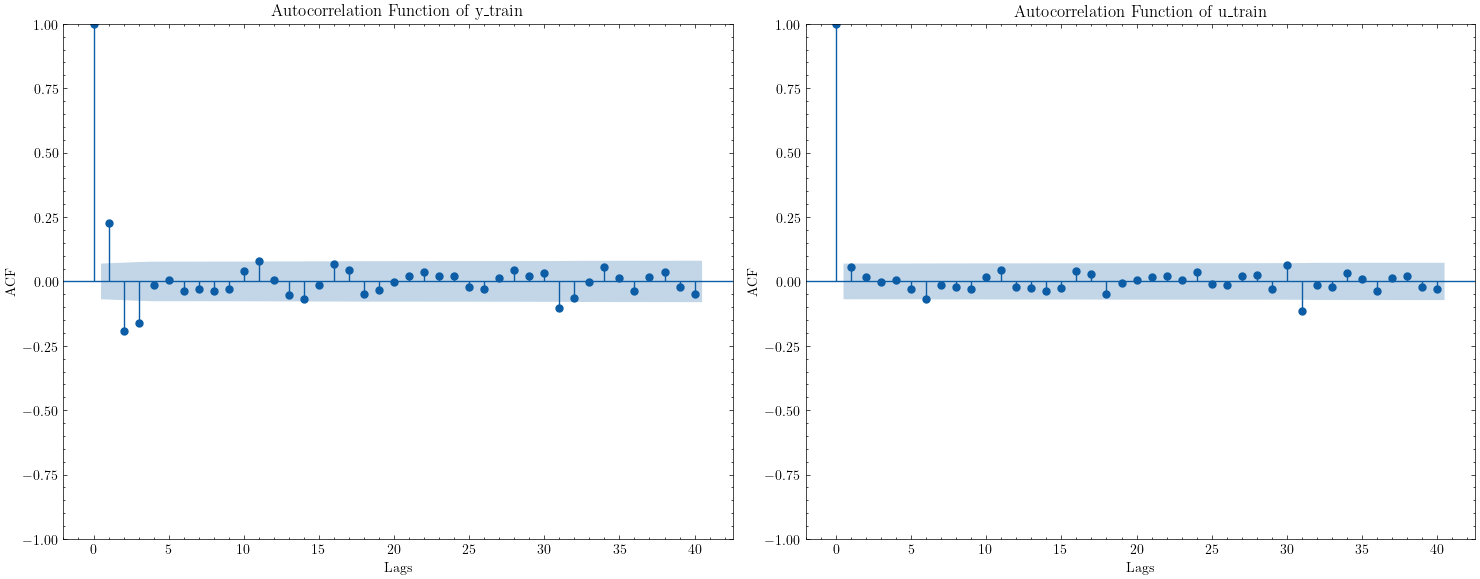

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first autocorrelation function
plot_acf(y_train, lags=40, alpha=0.05, ax=axs[0])
axs[0].set_title("Autocorrelation Function of y_train")
axs[0].set_xlabel("Lags")
axs[0].set_ylabel("ACF")

# Plot the second autocorrelation function
plot_acf(u_train, lags=40, alpha=0.05, ax=axs[1])
axs[1].set_title("Autocorrelation Function of u_train")
axs[1].set_xlabel("Lags")
axs[1].set_ylabel("ACF")

# Adjust layout
plt.tight_layout()
plt.savefig("../img/autocorrelation_plots.pdf", format='pdf')
plt.show()


### Write a function to fit a linear regression on the lags, namely an ARX model

In [49]:
def fit_arx_model(y, u, na, nb):
    """
    :param y: Target time series.
    :param x: Exogenous time series.
    :param na: Order of the autoregressive part.
    :param nb: Order of the exogenous input part.
    :return: Coefficients of A, B and the intercept of the ARX model.
    """
    max_lag = max(na, nb)
    features = []
    target = y[max_lag:]

    for i in range(max_lag, len(y)):
        lag_y = y[i-na:i] if na > 0 else []
        lag_u = u[i-nb:i] if nb > 0 else []
        row = np.concatenate([lag_y, lag_u])
        features.append(row)

    U = np.array(features)
    model = LinearRegression().fit(U, target)
    return model.coef_[:na], model.coef_[na:], model.intercept_

### Print and store the estimated paramters

In [50]:
# Fit ARX model and get A, B coefficients and intercept
na, nb = 2, 2
coefficients_a, coefficients_b, intercept = fit_arx_model(y_train, u_train, na, nb)

our_linear_model_results = pd.DataFrame({
    'Regressors': [f'y(t-{i})' for i in reversed(range(1, na+1))] + [f'u(t-{i})' for i in reversed(range(1, nb+1))] + ['1'],
    'Parameters': list(coefficients_a) + list(coefficients_b) + [intercept],
    'Source': 'Our Model'
}).set_index("Regressors").sort_index()
print(our_linear_model_results)

            Parameters     Source
Regressors                       
1             0.002977  Our Model
u(t-1)        0.695373  Our Model
u(t-2)       -0.194563  Our Model
y(t-1)        0.491774  Our Model
y(t-2)       -0.300984  Our Model


### Framework1 1: Gekko

In [51]:
from gekko import GEKKO

m = GEKKO()

# system identification
t = np.arange(0, len(u_train))
na = 2 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t, u_train, y_train, na, nb, pred='meas')

gekko_model_results = pd.DataFrame({
    'Regressors': [f'y(t-{i})' for i in range(1, na+1)] + [f'x(t-{i})' for i in range(1, nb+1)] + ['1'],
    'Parameters': list(p["a"].squeeze()) + list(p["b"].squeeze()) + [p["c"][0]],
    'Source': 'Gekko'
}).set_index("Regressors").sort_index()
print(gekko_model_results)

            Parameters Source
Regressors                   
1             0.002977  Gekko
x(t-1)        0.695373  Gekko
x(t-2)       -0.194563  Gekko
y(t-1)        0.491774  Gekko
y(t-2)       -0.300984  Gekko


In [52]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

## Framework2: SysIdentipy

In [53]:
basis_function = Polynomial(degree=1)

model = FROLS(
    order_selection=False,
    n_terms=5,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    estimator="least_squares",
    basis_function=basis_function,
)

model.fit(X=u_train.reshape(-1,1), y=y_train.reshape(-1,1))

/home/alqua/anaconda3/envs/dl_env/lib/python3.10/site-packages/sysidentpy/narmax_base.py:170: RuntimeWarning: divide by zero encountered in divide
  x = x[1:] / aux_b
/home/alqua/anaconda3/envs/dl_env/lib/python3.10/site-packages/sysidentpy/narmax_base.py:198: RuntimeWarning: invalid value encountered in multiply
  w = b * np.dot(RA.T, v)


In [54]:
from sysidentpy.utils.display_results import results

sysidentpy_model_results = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=4,
        dtype="dec",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)[["Regressors", "Parameters"]].set_index("Regressors").sort_index()
print(sysidentpy_model_results)

           Parameters
Regressors           
1              0.0030
x1(k-1)        0.6954
x1(k-2)       -0.1946
y(k-1)         0.4918
y(k-2)        -0.3010


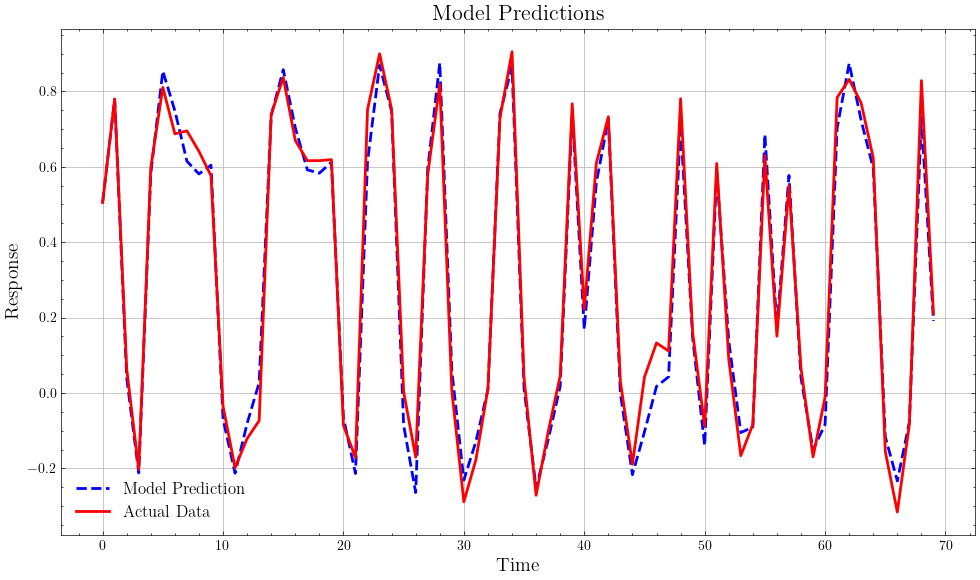

In [55]:
yhat = model.predict(X=u_test.reshape(-1,1), y=y_test.reshape(-1,1)).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(yhat[:STEPS], label='Model Prediction', color='blue', linewidth=2, linestyle='--')
plt.plot(y_test[:STEPS], label='Actual Data', color='red', linewidth=2)

# Enhancing the plot with additional features
plt.title('Model Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Response', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.savefig('../img/response_yhat.pdf', format='pdf')
plt.show()

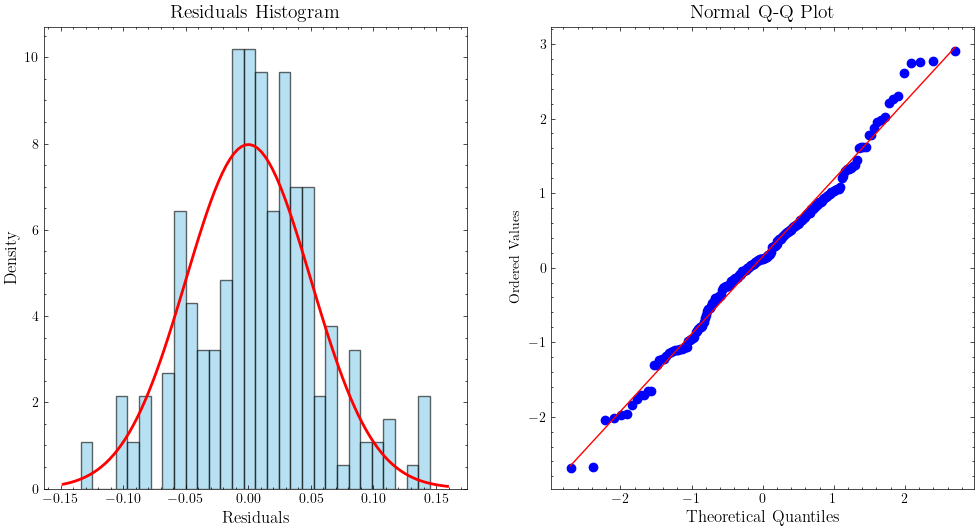

Shapiro-Wilk test result: statistic=0.9897, p-value=0.1603
The residuals are compatible with a Gaussian distribution.


In [56]:
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats

residuals = y_test - yhat

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)

# Compare with a Gaussian distribution
mu = 0
sigma = 0.05
z_scores = (residuals - mu) / sigma

# Creating a PDF file to save plots
pdf = PdfPages("../img/residuals_analysis.pdf")

# Plotting in a more aesthetic manner
plt.figure(figsize=(12, 6))

# Histogram of the residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
plt.title("Residuals Histogram", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Density", fontsize=12)

# QQ plot
plt.subplot(1, 2, 2)
stats.probplot(z_scores, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)

# Saving the figure to PDF
pdf.savefig()
plt.show()
plt.close()

# Closing the PDF object
pdf.close()

# Output the results of the Shapiro-Wilk test
shapiro_result = f"Shapiro-Wilk test result: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}"
compatibility_result = "The residuals are compatible with a Gaussian distribution." if shapiro_test[1] > 0.05 else "The residuals are not compatible with a Gaussian distribution."
print(f"Shapiro-Wilk test result: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}")
print("The residuals are compatible with a Gaussian distribution." if shapiro_test[1] > 0.05 else "The residuals are not compatible with a Gaussian distribution.")